The work is split into four notebooks:
1.   Path Simulation and Variance Comparison
2.   Functions Set-up
3.   Analysis on S&P 500
4.   Analysis on STOXX Europe 600

# **Section 1. Path Simulation and Variance Comparison**

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.stats import norm
import seaborn as sns

In this notebook we simply provide a direct comparison of the Black-Scholes-Merton and Jump Diffusion models. We simulate the price paths with the two different models to prove that the latter produces a higher variance than the former.

In [ ]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [ ]:
def BS_simulate(S, r, q, sigma, dt):
  '''
  Simulate the stock price according to Black-Scholes model 
  in the time interval dt
  
  S: starting stock price
  r: annualized continuous risk-free interest rate 
  q: continuos dividend yield of the underlying asset
  sigma: annualized volatility of the underlying asset
  dt: time interval
  '''
  return S * np.exp((r - q - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * np.random.randn())

def JDM_simulate(S, r, q, sigma, dt, l, a, b):
  '''
  Simulate the stock price according to Jump diffusion model 
  in the time interval dt having as log-jumps' distribution 
  a Normal with mean a and volatility b

  S: starting stock price
  r: annualized continuous risk-free interest rate 
  q: continuos dividend yield of the underlying asset
  sigma: annualized volatility of the underlying asset
  dt: time interval
  l: lambda parameter for the Poisson distribution (Merton assumption of unit phi is assumed)
  a: mean of the logarithm of the jump distribution
  b: standard deviation of the logarithm of the jump distribution
  '''
  N = np.random.poisson(l * dt)
  if N > 0:
    Y = np.exp(np.random.randn() * b * np.sqrt(N) + a * N)
  else:
    Y = 1
  m = np.exp(a + 0.5 * b**2) - 1
  return BS_simulate(S, r - m * l, q, sigma, dt) * Y

def path_simulations(simulations, T, intervals, model, S, **kwargs):
  '''
  Simulate the paths of a stock price according to different models
  and save them in a dataframe

  simulations: number of simulations you want to perform
  T: time horizon
  intervals: number of intermediate steps at which you want to simulate your stock
  model: BS_simulate or JDM_simulate
  S: initial stock price

  **kwargs: all other parameters that you need to furnish to your model;
  Allowed parameters:
    r: annualized continuous risk-free interest rate 
    q: continuos dividend yield of the underlying asset
    sigma: annualized volatility of the underlying asset
    dt: time interval
    l: lambda parameter for the Poisson distribution
    a: mean of the logarithm of the jump distribution
    b: standard deviation of the logarithm of the jump distribution 
  '''

  df = pd.DataFrame(columns = range(0, intervals + 1))
  df.loc[:, 0] = [S] * simulations
  for j in range(simulations):
    for i in range(1, intervals + 1):
      df.loc[j, i] = model(S = df.loc[j, i - 1], dt = T / intervals, **kwargs)
  return df

In [ ]:
df_BS = path_simulations(10000, 1, 12, BS_simulate, S = 50, r = 0.005, q = 0, sigma = 0.1)
df_JD = path_simulations(10000, 1, 12, JDM_simulate, S = 50, r = 0.005, q = 0, sigma = 0.1, l = 2, a = 0.05, b = 0.001)

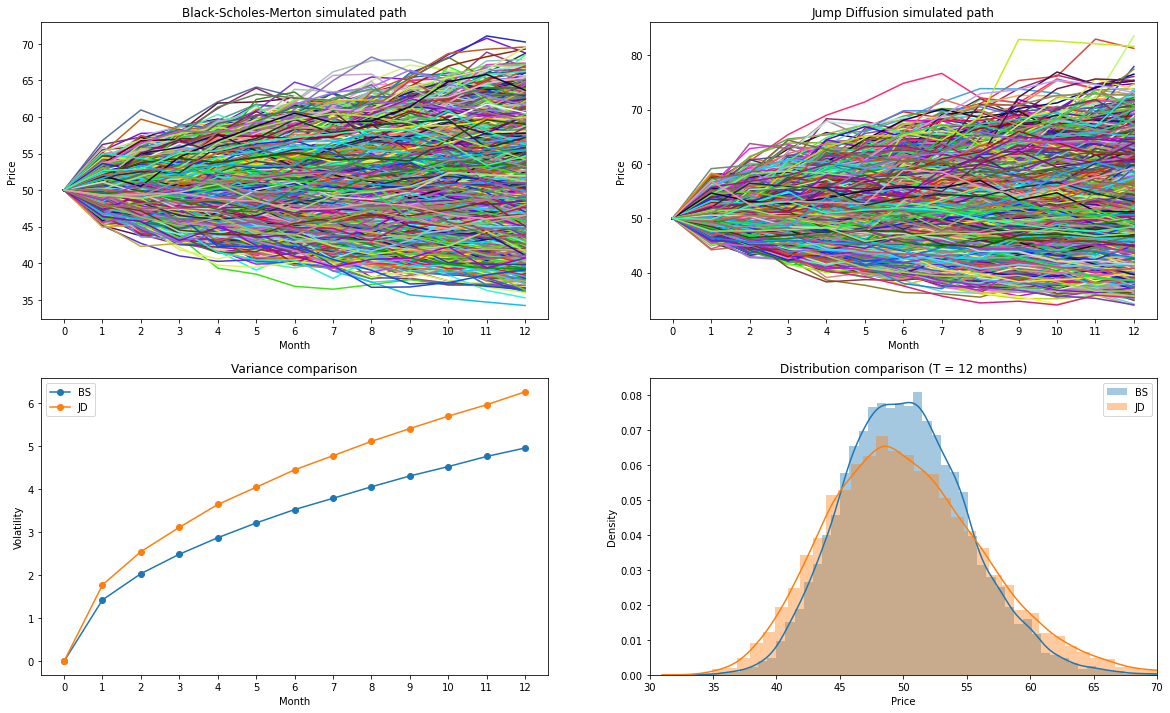

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (20, 12))
M = 12
for i in range(df_BS.shape[0]):
  color = np.random.rand(3)
  ax[0,0].plot(df_BS.loc[i, :], c = color)
  ax[0,1].plot(df_JD.loc[i, :], c = color)

ax[0,0].set_title('Black-Scholes-Merton simulated path')
ax[0,0].set_xticks(range(M + 1))
ax[0,0].set_xlabel('Month')
ax[0,0].set_ylabel('Price')

ax[0,1].set_title('Jump Diffusion simulated path')
ax[0,1].set_xticks(range(M + 1))
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Price')

ax[1,0].plot(df_BS.std(axis = 0),'-o',label = 'BS')
ax[1,0].plot(df_JD.std(axis = 0),'-o',label = 'JD')
ax[1,0].set_title('Variance comparison')
ax[1,0].set_xticks(range(M + 1))
ax[1,0].set_xlabel('Month')
ax[1,0].set_ylabel('Volatility')
ax[1,0].legend()

sns.distplot(df_BS.iloc[:, -1], label = 'BS')
ax[1,1]=sns.distplot(df_JD.iloc[:,-1], label = 'JD')
ax[1,1].set_title('Distribution comparison (T = 12 months)')
ax[1,1].set_xlim(30, 70)
ax[1,1].set_xlabel('Price')
ax[1,1].legend()

plt.show()

# **Section 2. Functions Set-up**

In this notebook we need to create some functions that will help us find the implied volatility according to the different frameworks of Black-Merton-Scholes and the jump diffusion model.
After that, we will find the parameter by minimizing the difference between the theoretical and the market price of the options. We can do that by using Gradient descent.

The following function finds the price of the call option in the Black-Merton-Scholes framework:

In [ ]:
def Price_Option_BMS (option_type, S, K, r, q, sigma, T):
    '''
    returns the price of a plain vanilla European option on assets 
    paying a continuos dividend yield using the Black-Merton-Scholes model
    
    option_type: call/put option
    S: spot price of the underlying asset
    K: strike price
    r: annualized continuous risk-free interest rate 
    q: continuos dividend yield of the underlying asset
    sigma: annualized volatility of the underlying asset
    T: annualized time to expiration
    '''    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    if option_type.upper().startswith('C'): # call option
      return call_price
    elif option_type.upper().startswith('P'): # put option
      put_price = K * np.exp(-r * T) - S * np.exp(-q * T) + call_price # put-call parity
      return put_price

The next one does the same in the jump diffusion model elaborated by Merton:

In [ ]:
def Price_Option_JD (option_type, S, K, r, q, sigma, T, lambdaP, a, b, phi = 1, N = 50):
  '''
    returns the price of a plain vanilla European option on assets
    paying a continuos dividend yield using the Jump Diffusion model;
    a plurality of risk-neutral are accepted by setting the risk aversion parameter;
    Jumps are modelled as lognormal random variables

    option_type: call/put option
    S: spot price of the underlying asset
    K: strike price
    r: annualized continuous risk-free interest rate 
    q: continuos dividend yield of the underlying asset
    sigma: annualized volatility of the underlying asset
    T: annualized time to expiration
    lambdaP: lambda parameter for the Poisson distribution under the historical probability measure
    a: mean of the logarithm of the jump distribution
    b: standard deviation of the logarithm of the jump distribution
    phi: (optional) risk aversion parameter, default value is 1
    N: (optional) number of terms in the summation of BMS options (i.e. number of jumps to be considered), default value is 50
    '''  
  # expected value of one jump under the risk-neutral probability measure:
  miY = np.exp(a + 0.5 * b**2)
  m = miY - 1
  # lambda parameter for the Poisson distribution under the risk-neutral probability measure:
  lambdaQ = phi * lambdaP
  lambda_prime = lambdaQ * miY

  # computation of the probability-weighted summation of BMS options
  call_price = 0
  for n in range(1, N + 1):
    r_n = r - m * lambdaQ + n * np.log(miY) / T
    sigma_n =np.sqrt((sigma**2 * T + n * b**2) / T)
    call_price += np.exp(-lambda_prime * T) * (lambda_prime * T)**n / math.factorial(n) * \
    Price_Option_BMS('Call', S, K, r_n, q, sigma_n, T)
  
  if option_type.upper().startswith('C'): # call option
    return call_price
  elif option_type.upper().startswith('P'): # put option
    put_price = K * np.exp(-r * T) - S * np.exp(-q * T) + call_price # put-call parity
    return put_price

To check whether the models give us reasonable results, the try to compute the price of a European call using the two functions previously defined:

In [ ]:
# Example of a call option priced through Black-Merton-Scholes:
BMS_price = Price_Option_BMS (option_type='call', S = 100, K = 95, r = 0.02, q = 0.01, sigma = 0.2, T = 1)
print('The price of the option in the BMS model is', round(BMS_price, 4))

# Example of a call option priced through the jump diffusion model:
JD_price = Price_Option_JD (option_type='call', S = 100, K = 95, r = 0.02, q = 0.01, \
                             sigma = 0.2, T = 1, lambdaP = 1, a = 0.15, b = 0.01)
print('The price of the option in the JD model is', round(JD_price, 4))

The price of the option in the BMS model is 10.9502
The price of the option in the JD model is 11.5238


In [ ]:
def find_IV_JD (option_type, S, K, r, q, T, lambdaP, a, b, actual_price, phi = 1, N = 50):  '''
  Find the implied volatility with the JD framework

  option_type: (str) 'C' for call option and 'P' for put
  S: spot price of the underlying asset
  K: strike price
  r: annualized risk-free interest rate 
  q: continuos dividend yield of the underlying asset
  T: annualized time to expiration
  lambdaP: lambda parameter for the Poisson distribution under the historical probability measure
  a: mean of the logarithm of the jump distribution
  b: standard deviation of the logarithm of the jump distribution
  phi: (optional) risk aversion parameter, default value is 1
  N: (optional) number of terms in the summation of BMS options (i.e. number of jumps to be considered), default value is 50
  '''
  func = lambda sigma: Price_Option_JD (option_type, S, K, r, q, sigma, T, lambdaP, a, b, phi, N)
  f = lambda sigma:(func(sigma) - actual_price)**2
  bnds = [(0, None)]
  cons = {'type': 'ineq', 'fun': lambda x:  x}
  result = opt.minimize(f, 0.5, method = 'SLSQP', bounds = bnds, constraints = cons)  
  return result

# **Section 3. Analysis on S&P 500**

The data points that we retrieved from Bloomberg for the SPX options are stored in two vectors, one for each option type:

In [ ]:
call_prices = [114.4, 110.8, 107.15, 103.6, 100.35, 96.85, 93.65, 90.25, 88.65, 84.35, 81.25, 78.15, 75.2, 72.25, 68.9, 66.15, 63.45, 61.3, 58.1, 55.55, 53.5, 51.4, 49.15, 46.6, 44.75]
put_prices = [56.5, 57.85, 59.85, 61.35, 62.4, 62.55, 65.4, 67.1, 69.1, 70.7, 72.6, 74.7, 76.8, 79.4, 80.75, 82.95, 85.3, 87.65, 90, 92.8, 95.6, 98.25, 100.5, 103.15, 106.65]

The following section performs the minimization procedure for different levels of the mean of the log jumps (from -0.2 to 0.2) and stores the values of the relevant quantity in vectors:

In [ ]:
# Vector of implied volatilities for the call options:
jiv_call = []
# Vector of implied volatilities for the put options:
jiv_put = []
# Vector of strike prices:
strikes = []
# Vector of means for the log jump i.e. a:
alphas = []

for K, actual_call_price, actual_put_price in zip(range(3550, 3675, 5), call_prices, put_prices):
  for a in np.linspace(-0.2, 0.2, 10):
    update_call = find_IV_JD (option_type = 'C', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = a, b = 0.15, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = a, b = 0.15, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    alphas.append(a)

Now we plot the results:

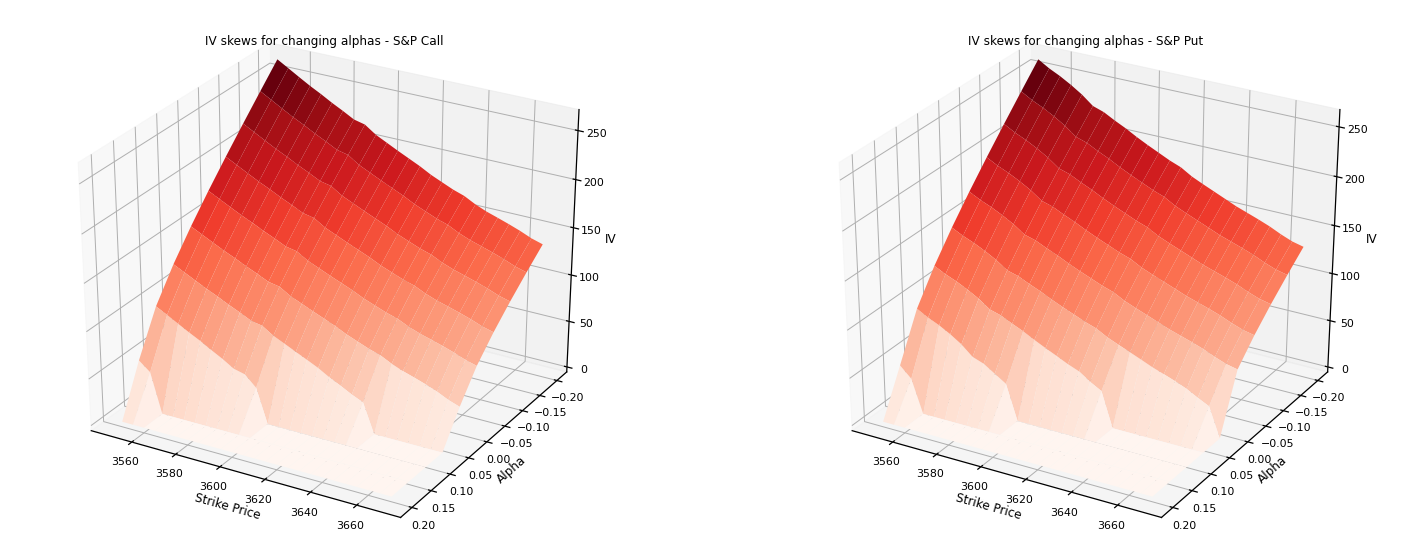

In [ ]:
#%matplotlib notebook

sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(25, 10)
y = np.array(alphas).reshape(25, 10)
z = np.array(jiv_call).reshape(25, 10)
ax.plot_surface(x, y, z, cmap = 'Reds')

ax.view_init(30, 120)
ax.set_title('IV skews for changing alphas - S&P Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Alpha')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(25, 10)
ax.plot_surface(x, y, z1, cmap = 'Reds')

ax.view_init(30, 120)
ax.set_title('IV skews for changing alphas - S&P Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Alpha')
ax.set_zlabel('IV')

plt.show()

The procedure is repeated for different levels of the volatility of the log jump (from 5% to 25%):

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
# Vector of volatilities for the log jump:
betas = []

for K, actual_call_price, actual_put_price in zip(range(3550, 3675, 5), call_prices, put_prices):
  for b in np.linspace(0.05, 0.25, 10):
    update_call = find_IV_JD (option_type = 'C', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = 0.05, b = b, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = 0.05, b = b, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    betas.append(b)

The results are plotted:

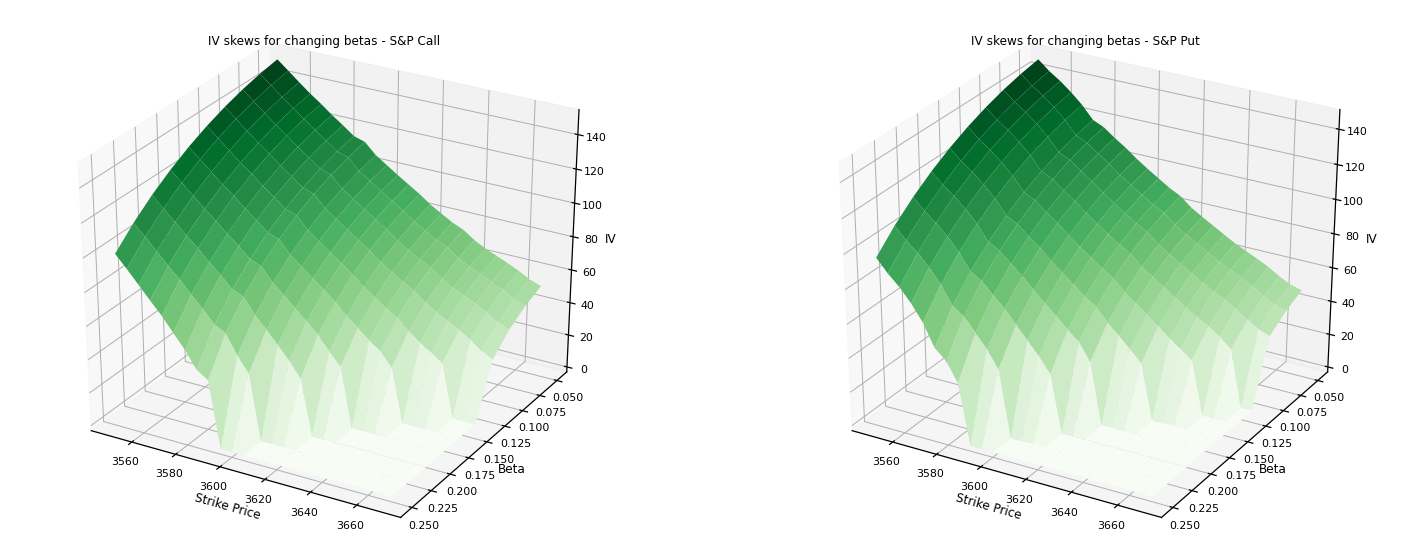

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(25, 10)
y = np.array(betas).reshape(25, 10)
z = np.array(jiv_call).reshape(25, 10)
ax.plot_surface(x, y, z, cmap = 'Greens')

ax.view_init(30, 120)
ax.set_title('IV skews for changing betas - S&P Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Beta')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(25, 10)
ax.plot_surface(x, y, z1, cmap = 'Greens')

ax.view_init(30, 120)
ax.set_title('IV skews for changing betas - S&P Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Beta')
ax.set_zlabel('IV')

plt.show()

Again, the minimization is performed, now for changing lambda parameters of the Poisson distribution under the historical measure (from 1 to 4): 

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
# Vector of lambdas for the Poisson distribution under the P-measure:
lambdas = []

for K, actual_call_price, actual_put_price in zip(range(3550, 3675, 5), call_prices, put_prices):
  for l in np.linspace(1, 4, 4):
    update_call = find_IV_JD (option_type = 'C', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = l, a = 0.05, b = 0.15, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = l, a = 0.05, b = 0.15, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    lambdas.append(l)

We plot the results:

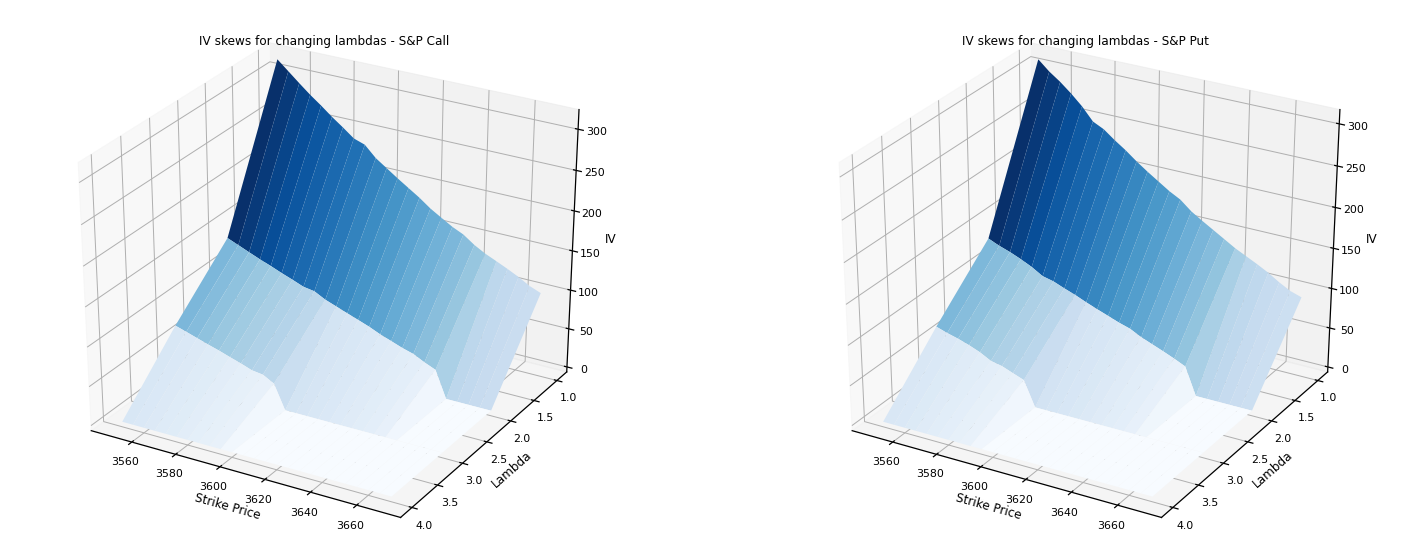

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(25, 4)
y = np.array(lambdas).reshape(25, 4)
z = np.array(jiv_call).reshape(25, 4)
ax.plot_surface(x, y, z, cmap = 'Blues')

ax.view_init(30, 120)
ax.set_title('IV skews for changing lambdas - S&P Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Lambda')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(25, 4)
ax.plot_surface(x, y, z1, cmap = 'Blues')

ax.view_init(30, 120)
ax.set_title('IV skews for changing lambdas - S&P Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Lambda')
ax.set_zlabel('IV')

plt.show()

As a last experiment, we minimize the price difference for different levels of phi, the risk aversion parameter (from 0.5 to 1.5). The other parameters are held constant with respect to previous minimizations:

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
# Vector of values for the risk aversion parameter:
phis = []

for K, actual_call_price, actual_put_price in zip(range(3550, 3675, 5), call_prices, put_prices):
  for phi in np.linspace(0.5, 1.5, 10):
    update_call = find_IV_JD (option_type = 'C', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = 0.05, b = 0.15, phi = phi, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 3609.53, K = K, r = 0.0023, q = 0.0144, T = 30/365, lambdaP = 2, a = 0.05, b = 0.15, phi = phi, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    phis.append(phi)

Finally, we plot the resulting volatility surface:

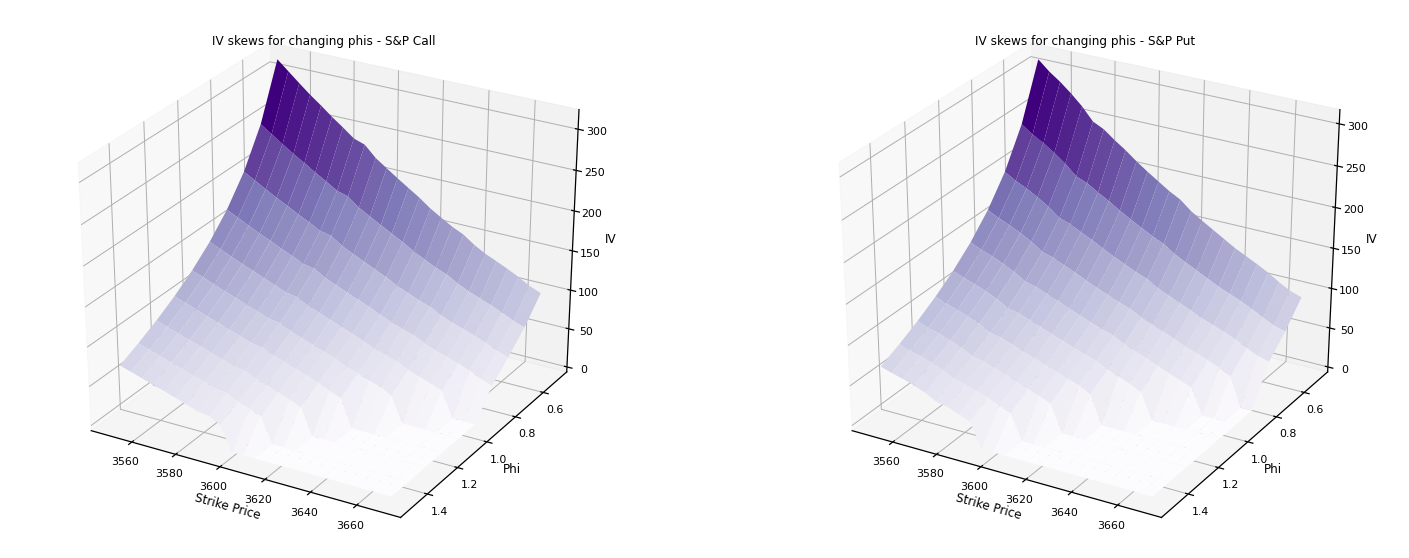

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(25, 10)
y = np.array(phis).reshape(25, 10)
z = np.array(jiv_call).reshape(25, 10)
ax.plot_surface(x, y, z, cmap = 'Purples')

ax.view_init(30, 120)
ax.set_title('IV skews for changing phis - S&P Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Phi')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(25, 10)
ax.plot_surface(x, y, z1, cmap = 'Purples')

ax.view_init(30, 120)
ax.set_title('IV skews for changing phis - S&P Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Phi')
ax.set_zlabel('IV')

plt.show()

# **Section 4. Analysis on STOXX Europe 600**

In this second part, we perform the same type of analysis on different index options, written on the STOXX Europe 600.
The data points that we retrieved for SXXP options are first stored in two vectors:

In [ ]:
call_prices=[32.1, 30.05, 27.7, 25.55, 23, 20.85, 19, 16.85, 15, 12.9, 11.05, 9.35, 7.9, 6.45, 5.2, 4.1, 3.1, 2.4, 1.8, 1.3, 0.9, 0.7]
put_prices=[1.5, 1.7, 1.9, 2.2, 2.5, 2.8, 3.2, 3.6, 4.2, 4.8, 5.5, 6.3, 7.2, 8.35, 9.55, 10.95, 12.45, 14.35, 16.2, 18.25, 20.4, 22.35]

From this point forward, the analysis is perfectly identical to what we did above for SXP options:

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
alphas = []

for K, actual_call_price, actual_put_price in zip(np.arange(357.5, 412.5, 2.5), call_prices, put_prices):
  for a in np.linspace(-0.2, 0.2, 10):
    update_call = find_IV_JD (option_type = 'C', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = a, b = 0.15, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = a, b = 0.15, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    alphas.append(a)

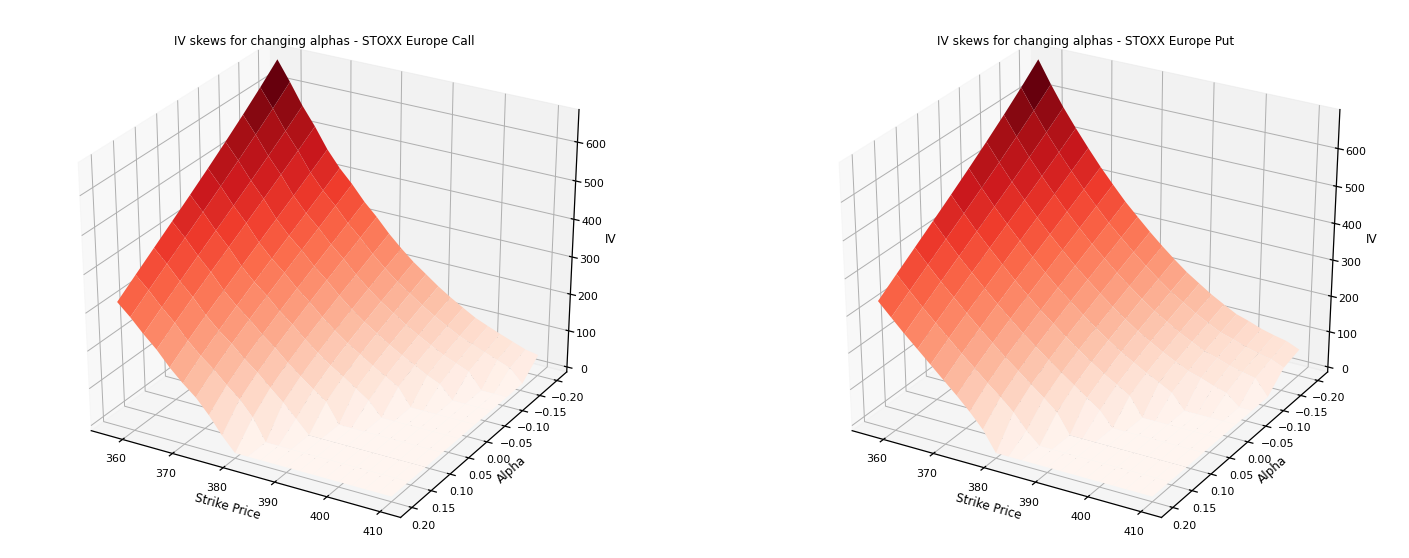

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(22, 10)
y = np.array(alphas).reshape(22, 10)
z = np.array(jiv_call).reshape(22, 10)
ax.plot_surface(x, y, z, cmap = 'Reds')

ax.view_init(30, 120)
ax.set_title('IV skews for changing alphas - STOXX Europe Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Alpha')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(22, 10)
ax.plot_surface(x, y, z1, cmap = 'Reds')

ax.view_init(30, 120)
ax.set_title('IV skews for changing alphas - STOXX Europe Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Alpha')
ax.set_zlabel('IV')

plt.show()

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
betas = []

for K, actual_call_price, actual_put_price in zip(np.arange(357.5, 412.5, 2.5), call_prices, put_prices):
  for b in np.linspace(0.05, 0.5, 10):
    update_call = find_IV_JD (option_type = 'C', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = 0.05, b = b, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = 0.05, b = b, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    betas.append(b)

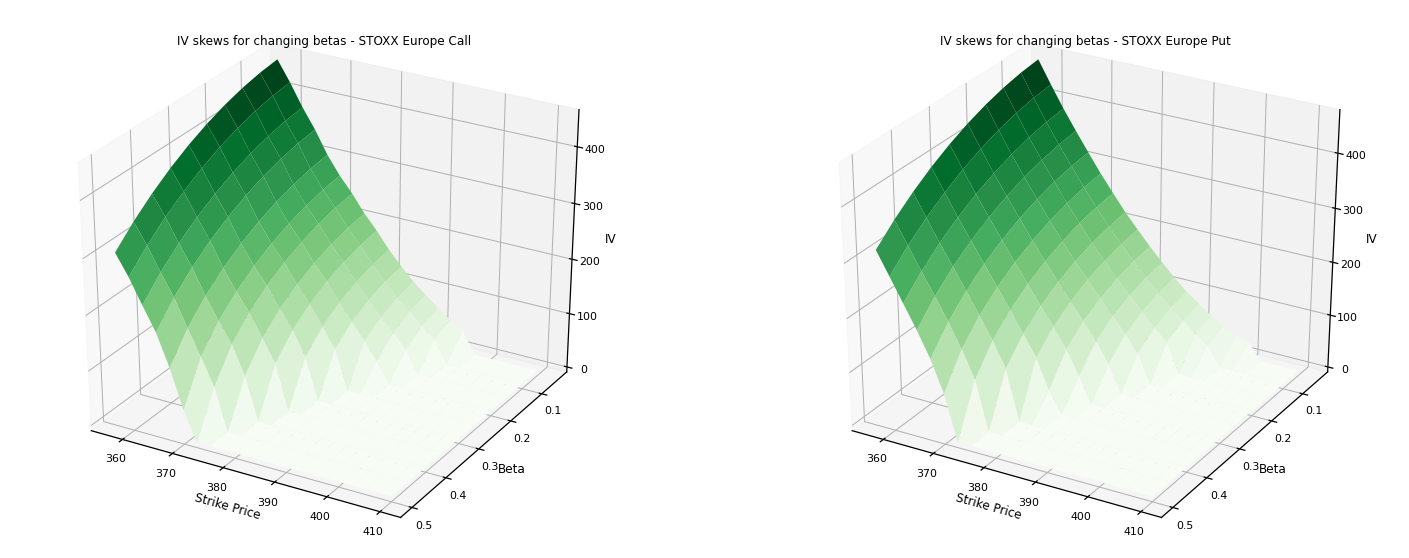

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(22, 10)
y = np.array(betas).reshape(22, 10)
z = np.array(jiv_call).reshape(22, 10)
ax.plot_surface(x, y, z, cmap = 'Greens')

ax.view_init(30, 120)
ax.set_title('IV skews for changing betas - STOXX Europe Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Beta')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(22, 10)
ax.plot_surface(x, y, z1, cmap = 'Greens')

ax.view_init(30, 120)
ax.set_title('IV skews for changing betas - STOXX Europe Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Beta')
ax.set_zlabel('IV')

plt.show()

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
lambdas = []

for K, actual_call_price, actual_put_price in zip(np.arange(357.5, 412.5, 2.5), call_prices, put_prices):
  for l in np.linspace(2,5, 4):
    update_call = find_IV_JD (option_type = 'C', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = l, a = 0.05, b = 0.15, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = l, a = 0.05, b = 0.15, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    lambdas.append(l)

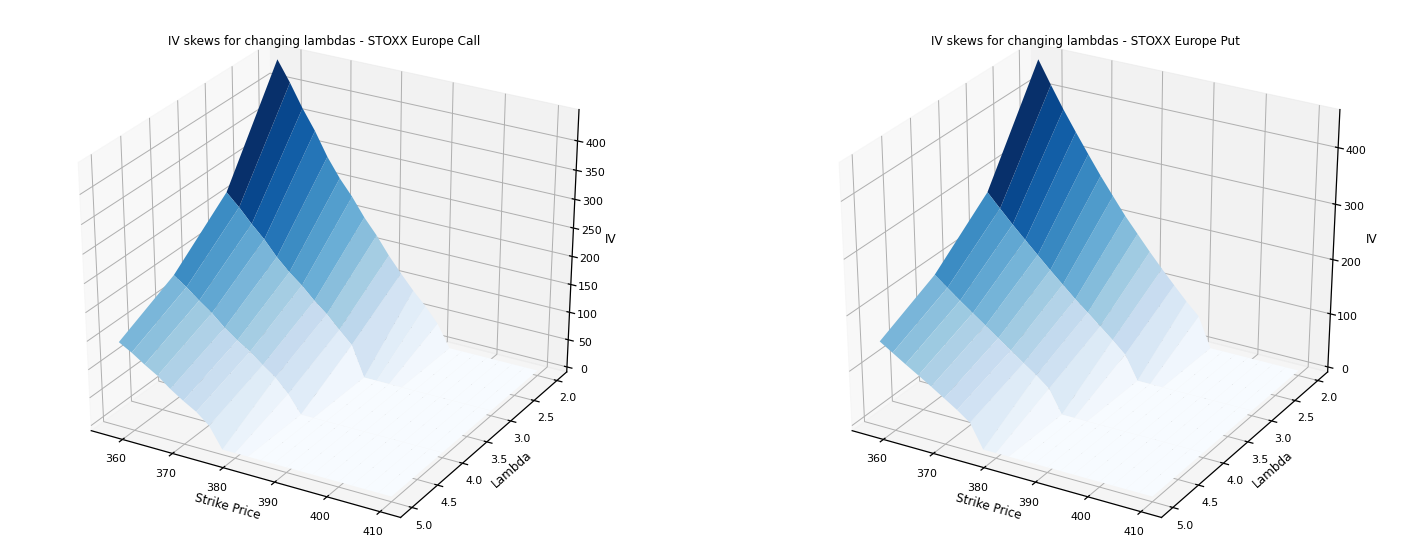

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(22, 4)
y = np.array(lambdas).reshape(22, 4)
z = np.array(jiv_call).reshape(22, 4)
ax.plot_surface(x, y, z, cmap = 'Blues')

ax.view_init(30, 120)
ax.set_title('IV skews for changing lambdas - STOXX Europe Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Lambda')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(22, 4)
ax.plot_surface(x, y, z1, cmap = 'Blues')

ax.view_init(30, 120)
ax.set_title('IV skews for changing lambdas - STOXX Europe Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Lambda')
ax.set_zlabel('IV')

plt.show()

In [ ]:
jiv_call = []
jiv_put = []
strikes = []
phis = []

for K, actual_call_price, actual_put_price in zip(np.arange(357.5, 412.5, 2.5), call_prices, put_prices):
  for phi in np.linspace(0.8, 1.2, 10):
    update_call = find_IV_JD (option_type = 'C', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = 0.05, b = 0.15, phi = phi, actual_price = actual_call_price).x
    update_put = find_IV_JD (option_type = 'P', S = 389.41, K = K, r = -0.0051, q = 0.0146, T = 30/365, lambdaP = 2, a = 0.05, b = 0.15, phi = phi, actual_price = actual_put_price).x
    jiv_call.append(update_call * 100)
    jiv_put.append(update_put * 100)
    strikes.append(K)
    phis.append(phi)

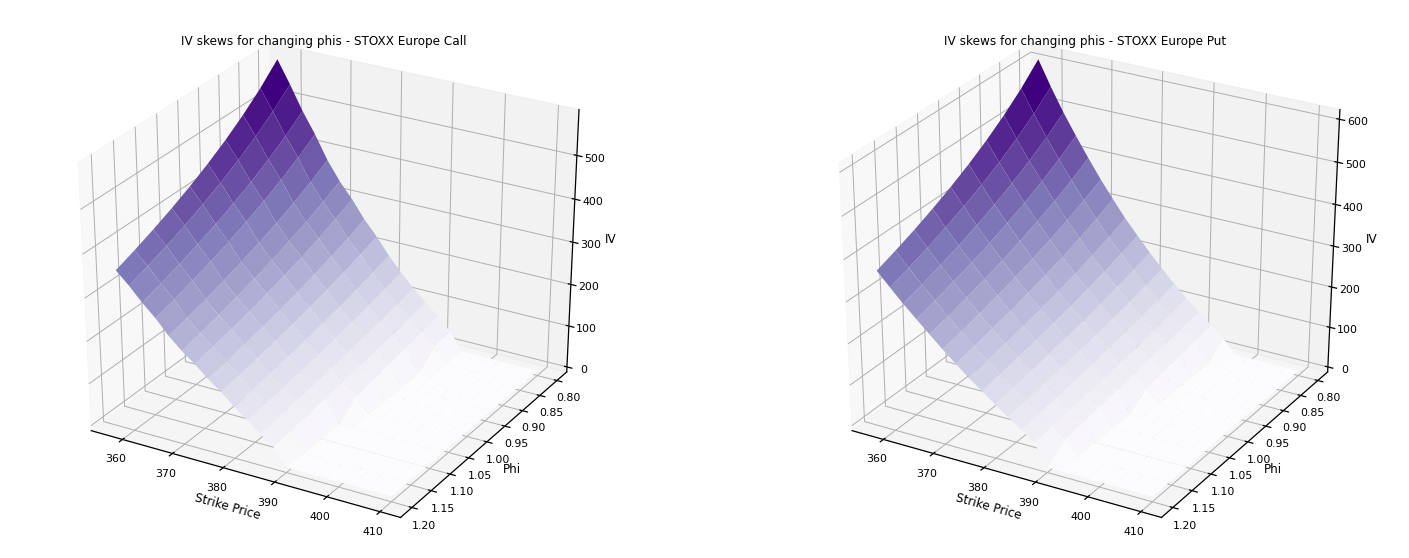

In [ ]:
sns.set_context('notebook')
fig = plt.figure(figsize = (25, 10))
ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.invert_yaxis()

x = np.array(strikes).reshape(22, 10)
y = np.array(phis).reshape(22, 10)
z = np.array(jiv_call).reshape(22, 10)
ax.plot_surface(x, y, z, cmap = 'Purples')

ax.view_init(30, 120)
ax.set_title('IV skews for changing phis - STOXX Europe Call')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Phi')
ax.set_zlabel('IV')

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.invert_yaxis()
 
z1 = np.array(jiv_put).reshape(22, 10)
ax.plot_surface(x, y, z1, cmap = 'Purples')

ax.view_init(30, 120)
ax.set_title('IV skews for changing phis - STOXX Europe Put')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Phi')
ax.set_zlabel('IV')

plt.show()